In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import scipy.signal as sig
from   scipy import stats
from   scipy import fftpack
import astropy.stats

from alderaan import noise
from alderaan import utils
pi = np.pi

# Heavy-tailed distributions

(0.9934785962104797, 0.2200799435377121)


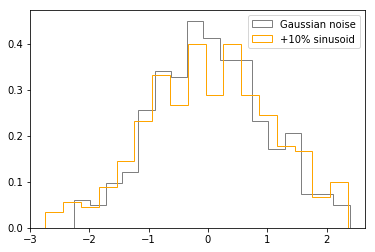

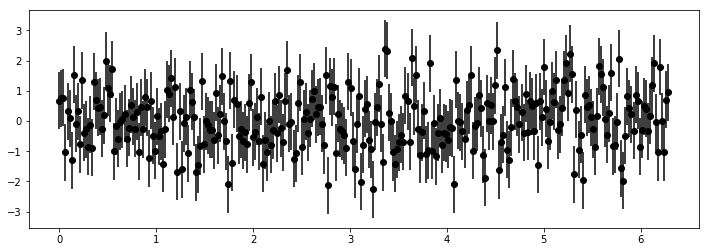

In [39]:
N = 300
s = 0.8

x = np.linspace(0,2*pi,N)

ynorm = np.random.normal(loc=0, scale=1, size=N)
ysin  = s*np.sin(x)
yuni  = np.random.uniform(low=-s, high=s, size=N)

print(stats.shapiro(ynorm+ysin))

plt.figure()
plt.hist(ynorm, histtype='step', color='grey', bins=int(np.sqrt(N)), density=True, label='Gaussian noise')
plt.hist(ynorm+ysin, histtype='step', color='orange', bins=int(np.sqrt(N)), density=True, label='+10% sinusoid')
#plt.hist(ynorm+yuni, histtype='step', color='mediumblue', bins=int(np.sqrt(N)), density=True)
plt.legend()
plt.show()


plt.figure(figsize=(12,4))
plt.errorbar(x, ynorm, yerr=np.std(ynorm), fmt='ko')
plt.show()


# Uncorrected TTV plot

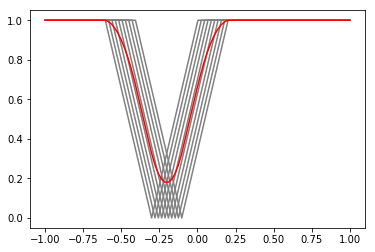

In [2]:
Npts = 1000
tri_size = 303

time = -np.linspace(-1,1,Npts)
flux = []

triangle = sig.windows.triang(tri_size)


for i in range(10):    
    flux.append(np.ones(Npts))
    flux[i][400+i*11:400+i*11+tri_size] -= triangle
    
    
flux = np.array(flux)
flux_mean = np.mean(flux, axis=0)


plt.figure()
for i in range(10):
    plt.plot(time, flux[i], c='grey')
plt.plot(time, flux_mean, c='red')
plt.show()



# Noise modeling with ACF

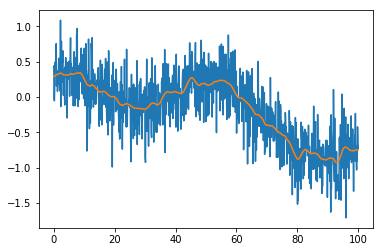

In [3]:
Npts = 1000

t = np.linspace(0,100,Npts)
y = 0.01*t -0.0002*t**2 + 0.3*np.sin(0.1*2*pi*t/5.2 + 1.3) + 0.3*np.random.normal(size=Npts)

plt.figure()
plt.plot(t, y)
plt.plot(t, utils.boxcar_smooth(y, 23))
plt.show()

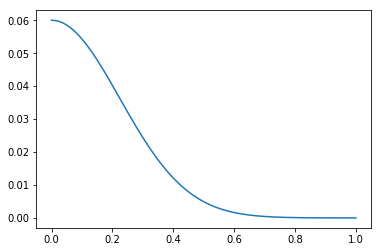

In [4]:
x = np.linspace(0,1,100)
dx = x[1]-x[0]

simple_acf = (np.exp(-x**2/0.1) - np.exp(-x.max()**2/0.1))*0.06
#simple_acf = (np.exp(-x/0.1) - np.exp(-x.max()/0.1))*0.06

plt.figure()
plt.plot(x, simple_acf)
plt.show()

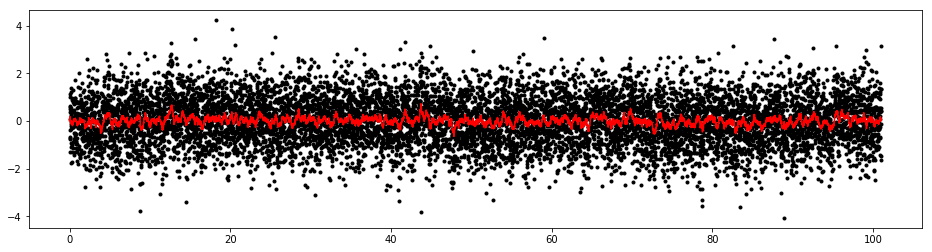

In [5]:
n = 10000
sigma = 1.0

covmatrix = noise.make_covariance_matrix(simple_acf, n)
L = np.linalg.cholesky(covmatrix)

# generate a vector of gaussian noise and remove any random covariance
z = np.random.normal(size=n)*sigma

# make correlated noise
t = np.arange(n)*dx
y = np.dot(L,z)

plt.figure(figsize=(16,4))
plt.plot(t, y, 'k.')
plt.plot(t, y-z, 'r')
plt.show()

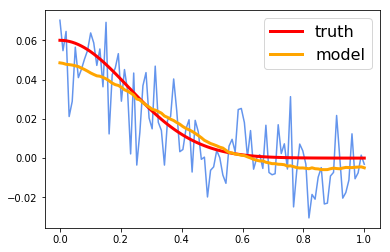

In [6]:
def generate_acf(x, y, cadno, Npts):
    dx = np.min(x[1:]-x[:-1])
    
    chunklist = noise.make_chunklist(x, y, cadno, Npts)
    Nsamples = chunklist.shape[0]
    
    D = np.zeros((Nsamples, Npts))

    for i, chunk in enumerate(chunklist):
        d = np.correlate(chunk, chunk, mode='full')
        D[i] = d[Npts+1:]/d[Npts]
        
    D = np.median(D, axis=0)

    return D


recovered_acf = generate_acf(t, y, np.arange(n), 5*len(x))

smooth_acf = np.hstack([recovered_acf[::-1], recovered_acf])
smooth_acf = sig.savgol_filter(smooth_acf, window_length=101, polyorder=3)[len(recovered_acf):]

plt.figure()
plt.plot(x, recovered_acf[:len(x)], c='cornflowerblue')
plt.plot(x, simple_acf, c='red', lw=3, label='truth')
plt.plot(x, smooth_acf[:len(x)], c='orange', lw=3, label='model')
plt.legend(fontsize=16)
plt.show()

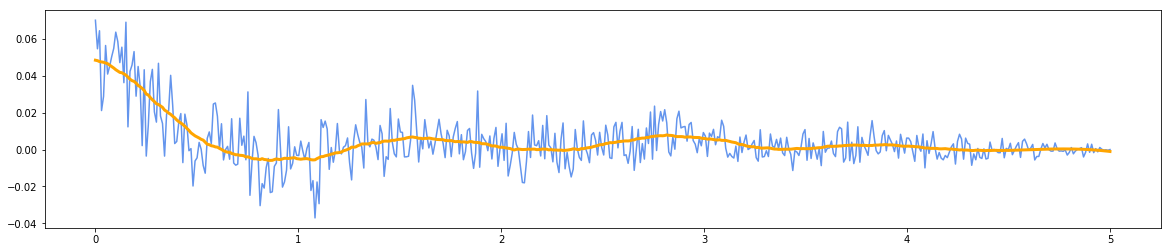

In [7]:
t500 = np.linspace(0,5,500)

plt.figure(figsize=(20,4))
plt.plot(t500, recovered_acf, color='cornflowerblue')
plt.plot(t500, smooth_acf, c='orange', lw=3)
plt.show()

# Lomb-Scargle estimator

In [ ]:
Npts = 19110

t = np.linspace(0,100,Npts)
y2 = 0.01*t -0.00014*t**2 + 0.03*np.sin(3.1*2*pi*t/5.2 + 1.3) + 0.3*np.random.normal(size=Npts)

plt.figure(figsize=(16,4))
plt.plot(t, y, 'cornflowerblue')
plt.show()

In [ ]:
def LS_estimator(x, y, fsamp=None, fap=0.1):
    """
    Generates a Lomb-Scargle periodogram and identifies significant frequencies from a data series
    Assumes that data are nearly evenly sampled
    
    Parameters
    ----------
    x : array-like
        1D array of x data values; should be monotonically increasing
    y : array-like
        1D array of corresponding y data values, len(x)
    fsamp: float
        nominal sampling frequency; if not provided it will be calculated from the data
    fap : float
        false alarm probability threshold to consider a frequency significate (default=0.1)
        
    Returns
    -------
    xf :
   
    yf :
   
    freqs :
   
    """
    # get sampling frequency
    if fsamp is None:
        fsamp = 1/np.min(x[1:]-x[:-1])
    
    # Hann window to reduce ringing
    hann = sig.windows.hann(len(x))
    hann /= np.sum(hann)
    
    # identify any egregious outliers
    local_trend = sig.medfilt(y, kernel_size=7)
    
    out = np.zeros_like(x)
    out = np.abs(y - local_trend)/astropy.stats.mad_std(y) > 5.0
    
    xt = x[~out]
    yt = y[~out]
    
    freqs = []
    loop = True
    while loop:
        lombscargle = astropy.stats.LombScargle(xt, yt*hann[~out])
        xf, yf = lombscargle.autopower(minimum_frequency=2.0/(xt.max()-xt.min()), \
                                       maximum_frequency=0.25*fsamp, \
                                       samples_per_peak=11)
    
        peak_freq = xf[np.argmax(yf)]
        peak_fap  = lombscargle.false_alarm_probability(yf.max(), method='bootstrap')
        
        # output first iteration of LS periodogram
        if len(freqs) == 0:
            xf_out = xf.copy()
            yf_out = yf.copy()
            levels = lombscargle.false_alarm_level([0.1, 0.01, 0.001])
        
        if peak_fap < fap:
            yt -= lombscargle.model(xt, peak_freq)*len(xt)
            freqs.append(peak_freq)
            
        else:
            loop = False
            
        if len(freqs) > 5:
            loop = False
            
    return xf_out, yf_out, freqs, levels

In [ ]:
xf, yf, freqs, levels = LS_estimator(t, y2)

In [ ]:
plt.figure()
plt.plot(xf, yf, c='lightgrey')
plt.show()

In [ ]:
xf, yf, freqs = LS_estimator(t, y2)

ysmooth = sig.wiener(yf, mysize=5)


plt.figure()
plt.plot(xf, yf, c='grey', lw=0.5)
#for f in freqs:
#    plt.axvline(f, c='orange')
#plt.axvline(xf[lowcut], c='orange')
#plt.xlim(0,15)
plt.show()

# Butterworth filter

In [ ]:
def butter_lowpass_filter(y, cutoff, fsamp, order=4):
    normal_cutoff = cutoff / (0.5*fsamp)
    
    # Get the filter coefficients 
    b, a = sig.butter(order, normal_cutoff, btype='lowpass', analog=False)
    
    yfilt = sig.filtfilt(b, a, y)
    
    return yfilt